# Clairvoyante (Model Training Demo)


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import numpy as np
import time
import pickle
from random import randrange

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import clairvoyante.utils_v2 as utils
import clairvoyante.clairvoyante_v2 as cv
import clairvoyante.param as param

Please run prepDataBeforeDemo.sh to generate training and testing data from BAM and VCF files before proceeding.

References:
1. The GIAB v3.3.2 NA12878 truth variant dataset is available at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/NA12878_HG001/NISTv3.3.2/GRCh38
2. The Illumina alignment is available at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/NA12878/NIST_NA12878_HG001_HiSeq_300x/, the chr21.bam and chr22.bam were extracted from the HG001.GRCh38_full_plus_hs38d1_analysis_set_minus_alts.300x.bam file, downsampled to 50x.

#### prepDataBeforeDemo.sh:
```
mkdir ../training
python ../dataPrepScripts/ExtractVariantCandidates.py --bam_fn ../testingData/chr21/chr21.bam --ref_fn ../testingData/chr21/chr21.fa --can_fn ../training/can_chr21 --ctgName chr21 --ctgStart 10269870 --ctgEnd 46672937 &
python ../dataPrepScripts/GetTruth.py --vcf_fn ../testingData/chr21/chr21.vcf --var_fn ../training/var_chr21 --ctgName chr21 &
python ../dataPrepScripts/ExtractVariantCandidates.py --bam_fn ../testingData/chr22/chr22.bam --ref_fn ../testingData/chr22/chr22.fa --can_fn ../training/can_chr22 --ctgName chr22 --ctgStart 18924717 --ctgEnd 49973797 &
python ../dataPrepScripts/GetTruth.py --vcf_fn ../testingData/chr22/chr22.vcf --var_fn ../training/var_chr22 --ctgName chr22 &
wait

python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr21/chr21.bam --can_fn ../training/can_chr21 --ref_fn ../testingData/chr21/chr21.fa --tensor_fn ../training/tensor_can_chr21 --ctgName chr21 --ctgStart 10269870 --ctgEnd 46672937 &
python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr22/chr22.bam --can_fn ../training/can_chr22 --ref_fn ../testingData/chr22/chr22.fa --tensor_fn ../training/tensor_can_chr22 --ctgName chr22 --ctgStart 18924717 --ctgEnd 49973797 &
python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr21/chr21.bam --can_fn ../training/var_chr21 --ref_fn ../testingData/chr21/chr21.fa --tensor_fn ../training/tensor_var_chr21 --ctgName chr21 --ctgStart 10269870 --ctgEnd 46672937 &
python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr22/chr22.bam --can_fn ../training/var_chr22 --ref_fn ../testingData/chr22/chr22.fa --tensor_fn ../training/tensor_var_chr22 --ctgName chr22 --ctgStart 18924717 --ctgEnd 49973797 &
wait

cat ../training/var_chr21 ../training/var_chr22 > ../training/var_mul
cat ../training/tensor_can_chr21 ../training/tensor_can_chr22 > ../training/tensor_can_mul
cat ../training/tensor_var_chr21 ../training/tensor_var_chr22 > ../training/tensor_var_mul
cat ../testingData/chr21/chr21.bed ../testingData/chr22/chr22.bed > ../training/bed
python ../dataPrepScripts/PairWithNonVariants.py --tensor_can_fn ../training/tensor_can_mul --tensor_var_fn ../training/tensor_var_mul --bed_fn ../training/bed --amp 2 --output_fn ../training/tensor_mix
python ../clairvoyante/tensor2Bin.py --tensor_fn ../training/tensor_mix --var_fn ../training/var_mul --bed_fn ../training/bed --bin_fn ../training/tensor.bin
```

## Train using the chr21+chr22 variants

In [3]:
# Load the preprocessed and compressed tensors into memory
with open("../training/tensor.bin", "rb") as fh:
    total = pickle.load(fh)
    XArrayCompressed = pickle.load(fh)
    YArrayCompressed = pickle.load(fh)
    posArrayCompressed = pickle.load(fh)

In [4]:
print >> sys.stderr, "The size of training dataset: {}".format(total)

The size of training dataset: 146101


In [5]:
# Pick a random candidate
i = randrange(total)
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

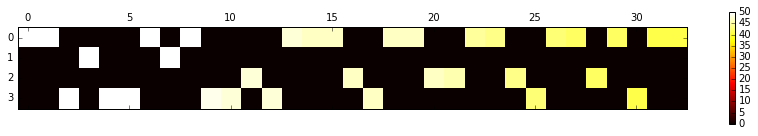

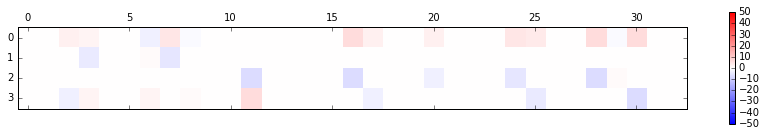

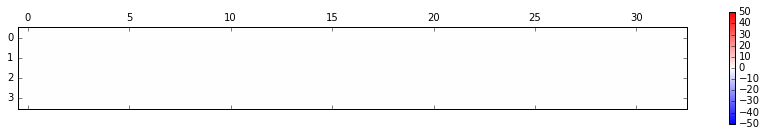

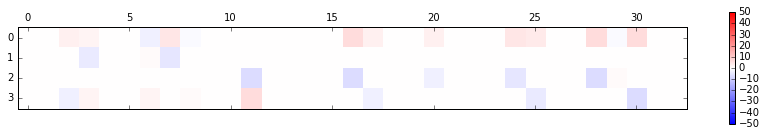

In [6]:
# Show how the four matrices are like
figure(figsize=(15, 2)); matshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.hot, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()

In [7]:
# create a Clairvoyante network
m = cv.Clairvoyante()
m.init()

In [8]:
# training the model. The code train on all variants and validate on the first 10% variant sites
trainingStart = time.time()
trainBatchSize = param.trainBatchSize
validationLosses = []
numValItems = int(len(XArray) * 0.1 + 0.499)
print >> sys.stderr, "Start at learning rate: %.2e" % m.setLearningRate(0.001)
c = 0; maxLearningRateSwitch = 2
epochStart = time.time()
datasetPtr = 0
numValItems = int(total * 0.1 + 0.499)
valXArray, _, _ = utils.DecompressArray(XArrayCompressed, 0, numValItems, total)
valYArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, numValItems, total)
print >> sys.stderr, "Number of variants for validation: %d" % len(valXArray)
i = 1
while i < (1 + int(param.maxEpoch * total / trainBatchSize + 0.499)):
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, trainBatchSize, total)
    YBatch, _, _ = utils.DecompressArray(YArrayCompressed, datasetPtr, trainBatchSize, total)
    loss, _ = m.train(XBatch, YBatch)
    if endFlag != 0:
        validationLoss = m.getLoss( valXArray, valYArray )
        print >> sys.stderr, " ".join([str(i),\
                                       "Training losses:", str(loss/trainBatchSize),\
                                       "Validation losses: ", str(validationLoss/numValItems),\
                                       "Epoch time elapsed: %.2f s" % (time.time() - epochStart)])
        validationLosses.append( (validationLoss, i) )
        c += 1
        flag = 0
        if c >= 5:
            if validationLosses[-5][0] - validationLosses[-4][0] < 0:
                if validationLosses[-4][0] - validationLosses[-3][0] > 0:
                    if validationLosses[-3][0] - validationLosses[-2][0] < 0:
                        if validationLosses[-2][0] - validationLosses[-1][0] > 0:
                            flag = 1
            elif validationLosses[-5][0] - validationLosses[-4][0] > 0:
                if validationLosses[-4][0] - validationLosses[-3][0] < 0:
                    if validationLosses[-3][0] - validationLosses[-2][0] > 0:
                        if validationLosses[-2][0] - validationLosses[-1][0] < 0:
                            flag = 1
            else: flag = 1
        if flag == 1:
            maxLearningRateSwitch -= 1
            if maxLearningRateSwitch == 0: break
            print >> sys.stderr, "New learning rate: %.2e" % m.setLearningRate()
            c = 0
        epochStart = time.time()
        datasetPtr = 0
    i += 1
    datasetPtr += trainBatchSize

print >> sys.stderr, "Training time elapsed: %.2f s" % (time.time() - trainingStart)

Start at learning rate: 1.00e-03
Number of variants for validation: 14610
15 Training losses: 1.70555898438 Validation losses:  2.86578702515 Epoch time elapsed: 109.32 s
29 Training losses: 1.27158730469 Validation losses:  1.9025668688 Epoch time elapsed: 102.01 s
43 Training losses: 0.94647421875 Validation losses:  1.49416228183 Epoch time elapsed: 119.56 s
57 Training losses: 0.838849804688 Validation losses:  1.32779453285 Epoch time elapsed: 98.15 s
71 Training losses: 0.78824296875 Validation losses:  1.25689663009 Epoch time elapsed: 99.68 s
85 Training losses: 0.746244921875 Validation losses:  1.16895988407 Epoch time elapsed: 98.87 s
99 Training losses: 0.674336572266 Validation losses:  1.06129042608 Epoch time elapsed: 97.80 s
113 Training losses: 0.621658886719 Validation losses:  0.979990896111 Epoch time elapsed: 96.54 s
127 Training losses: 0.57723359375 Validation losses:  0.903877441072 Epoch time elapsed: 95.09 s
141 Training losses: 0.532607226563 Validation losse

## Testing on the training dataset

In [9]:
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print >> sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart)

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print >> sys.stderr, "Version 2 model, evaluation on base change:"
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print >> sys.stderr, "all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100)
print >> sys.stderr, "Version 2 model, evaluation on Zygosity:"
ed = np.zeros( (2,2), dtype=np.int )
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(2)])
print >> sys.stderr, "Version 2 model, evaluation on variant type:"
ed = np.zeros( (4,4), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(4)])
print >> sys.stderr, "Version 2 model, evaluation on indel length:"
ed = np.zeros( (6,6), dtype=np.int )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(6)])

Prediciton time elapsed: 33.41 s
Version 2 model, evaluation on base change:
all/top1/top2/top1p/top2p: 146101/117687/140101/80.55/95.89
Version 2 model, evaluation on Zygosity:
58980	408
340	86373
Version 2 model, evaluation on variant type:
54227	129	5	2
136	78065	13	2
10	20	6680	4
23	3	11	6771
Version 2 model, evaluation on indel length:
132572	3	3	0	1	0
22	7405	18	4	4	13
13	19	2180	1	5	16
9	5	7	812	8	1
4	1	5	2	1197	14
15	7	2	3	3	1727


## Testing on the chr22 variants

In [10]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("../training/tensor_can_chr22",
                       "../training/var_chr22",
                       "../training/bed")
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

In [11]:
print >> sys.stderr, "Testing on the training and validation dataset ..."
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print >> sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart)

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print >> sys.stderr, "Version 2 model, evaluation on base change:"
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print >> sys.stderr, "all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100)
print >> sys.stderr, "Version 2 model, evaluation on Zygosity:"
ed = np.zeros( (2,2), dtype=np.int )
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(2)])
print >> sys.stderr, "Version 2 model, evaluation on variant type:"
ed = np.zeros( (4,4), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(4)])
print >> sys.stderr, "Version 2 model, evaluation on indel length:"
ed = np.zeros( (6,6), dtype=np.int )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(6)])

Testing on the training and validation dataset ...
Prediciton time elapsed: 15.78 s
Version 2 model, evaluation on base change:
all/top1/top2/top1p/top2p: 69761/60487/69536/86.71/99.68
Version 2 model, evaluation on Zygosity:
23809	103
86	45763
Version 2 model, evaluation on variant type:
35143	79	2	1
72	34366	4	0
1	9	62	0
1	3	0	18
Version 2 model, evaluation on indel length:
69664	2	1	0	0	0
3	51	0	0	0	0
4	1	12	0	0	0
2	0	0	5	0	0
3	0	0	0	2	0
3	0	0	0	0	8


## Visualizing predictions

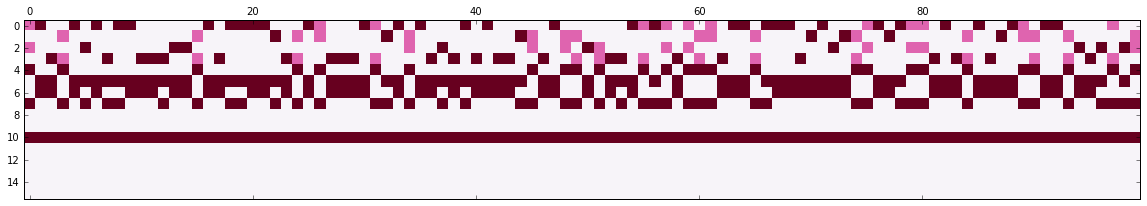

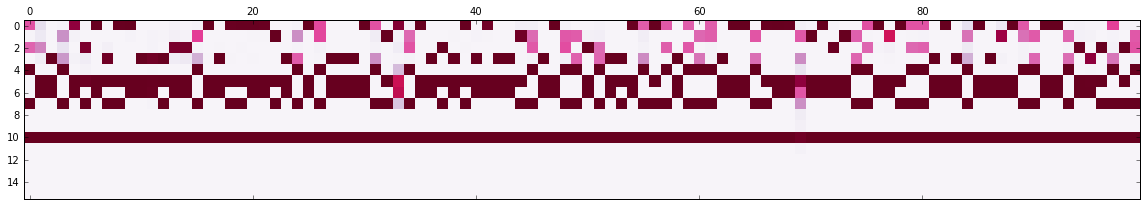

In [12]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],zs[arrayStart:arrayEnd,:],\
                         ts[arrayStart:arrayEnd,:],ls[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)